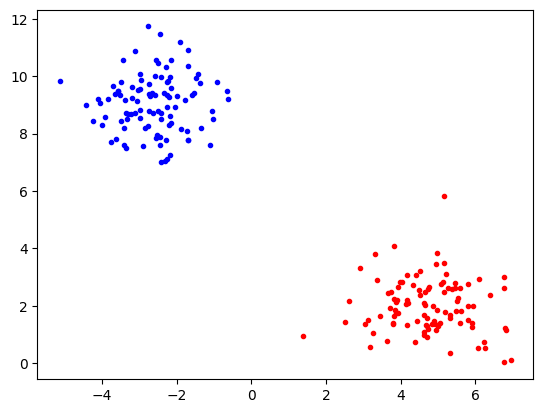

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(42)

X, y = make_blobs(n_samples=200, centers=2)
idxs_1 = np.argwhere(y==1)
idxs_0 = np.argwhere(y==0)
X1 = X[np.reshape(idxs_1, idxs_1.size)]
X0 = X[np.reshape(idxs_0, idxs_0.size)]

plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
y[y==0] -= 1

In [2]:
class SVM:
    """ 
    A regularized kernel SVM 
    
    ...

    Attributes
    ----------
    C : float
        The inverse regularization parameter
    kernel: str
        The kernel type (e.g. linear, gaussian_rbf, etc..)

    Methods
    -------
    train(X,y):
        Trains the model on the dataset (X,y)

    predict(q):
        Makes a prediction about query point q
    """
    def __init__(self, C, kernel="linear"):
        self.C = C
        self.kernel = kernel
        self.next_idx = 0
        self.b = 0
    
    def _float_equals(self, a, b, tol=1e-3):
        return abs(a - b) < tol

    def _alphas_on_boundary(self):
        N = self.K.shape[0]
        on_boundary = []
        off_boundary = []
        for i in range(N):
            if self._float_equals(self.alpha[i], 0) or self._float_equals(self.alpha[i], self.C):
                on_boundary.append(i)
            else:
                off_boundary.append(i)

        return on_boundary, off_boundary

    def plot_decision_boundary(self):
        x = np.linspace(-6, 8, 50)
        y = -(self.w[0] * x - self.b) / self.w[1]
        plt.figure()
        plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.', x, y, 'black')
    
    def train(self, X, y):
        """ Train the classifier using the SMO algorithm """
        self.X = X
        self.y = y
        
        N, D = self.X.shape

        # Picking feasible alpha
        self.alpha = np.zeros(N)
        self.errors = -self.y
        self.eps = 1e-3
        converged = False

        # Compute Kernel
        if self.kernel == "gaussian":
            self.K = self.compute_gaussian_kernel(self.X)
        else:
            self.w = np.zeros_like(self.X[0])
            self.K = self.compute_linear_kernel(self.X)

        numChanged = 0
        examineAll = True
        iterNum = 0
        while numChanged > 0 or examineAll:
            numChanged = 0
            if examineAll:
                for i in range(N):
                    numChanged += self._examine_example(i)
            else:
                for i in range(N):
                    if not self._float_equals(self.alpha[i], 0) and not self._float_equals(self.alpha[i], self.C):
                        numChanged += self._examine_example(i)

            if examineAll:
                examineAll = False
            else:
                examineAll = True
            
            #print(numChanged)
            # print("alpha norm: ", np.linalg.norm(self.alpha))
            # if self.kernel == "linear":
            #     print("w norm: ", np.linalg.norm(self.w))
            # print()
            # self.plot_decision_boundary()

    def _examine_example(self, idx):
        N, D = self.X.shape
        
        y2 = self.y[idx]
        alph2 = self.alpha[idx] 
        E2 = self.errors[idx]
        r2 = E2 * y2

        if (r2 < -self.eps and alph2 < self.C) or (r2 > self.eps and alph2 > 0):
            on_boundary_idxs, off_boundary_idxs = self._alphas_on_boundary()
            if len(on_boundary_idxs) > 1:
                if E2 > 0:
                    idx1 = np.argmin(self.errors)
                else:
                    idx1 = np.argmax(self.errors)

                if self._take_step(idx1, idx):
                    return 1

            # loop over all non-zero and non-C alpha, starting at a random point
            random.shuffle(off_boundary_idxs)
            for idx1 in off_boundary_idxs:
                if self._take_step(idx1, idx):
                    return 1

            idxs = list(range(N))
            random.shuffle(idxs)
            for idx1 in idxs:
                if self._take_step(idx1, idx):
                    return 1

        return 0

    def _take_step(self, idx1, idx2):
        N, D = self.X.shape
        
        if idx1 == idx2:
            return False

        alph1 = self.alpha[idx1]
        alph2 = self.alpha[idx2]
        y1 = self.y[idx1]
        y2 = self.y[idx2]
        E1 = self.errors[idx1]
        E2 = self.errors[idx2]

        s = y1 * y2

        if s < 0:
            L = max(0, alph2 - alph1)
            H = min(self.C, self.C + alph2 - alph1)
        else:
            L = max(0, alph2 + alph1 - self.C)
            H = min(self.C, alph2 + alph1)

        if L == H:
            return False

        k11 = self.K[idx1, idx1]
        k12 = self.K[idx1, idx2]
        k22 = self.K[idx2, idx2]

        eta = k11 + k22 - 2 * k12

        a2 = None
        if eta > 0:
            a2 = alph2 + y2 * (E1 - E2) / eta
            if a2 < L:
                a2 = L
            elif a2 > H:
                a2 = H

        else:
            f1 = y1 * (E1 + self.b) - alph1 * k11 - s * alph2 * k12
            f2 = y2 * (E2 + self.b) - s * alph1 * k12 - alph2 * k22
            L1 = alph1 + s * (alph2 - L)
            H1 = alph1 + s * (alph2 - H)
            
            # Objective function at a2=L
            Lobj = L1 * f1 + L * f2 + (1/2)*L1**2 * k11 + (1/2)*L**2 * k22 + s * L * L1 * k12
            
            # Objective function at a2=H
            Hobj = H1 * f1 + H * f2 + (1/2)*H1**2 * k11 + (1/2)*H**2 * k22 + s * H * H1 * k12

            if Lobj < (Hobj - self.eps):
                a2 = L
            elif Lobj > (Hobj + self.eps):
                a2 = H
            else:
                a2 = alph2

        if abs(a2 - alph2) < self.eps * (a2 + alph2 + self.eps):
            return False

        a1 = alph1 + s * (alph2 - a2)

        b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + self.b
        b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + self.b

        b1_valid = a1 != L and a1 != H
        b2_valid = a2 != L and a2 != H

        if b1_valid and b2_valid:
            assert self._float_equals(b1, b2)

        if b1_valid:
            self.b = b1
        elif b2_valid:
            self.b = b2
        else:
            if L != H:
                self.b = (b1 + b2) / 2
            else:
                print(f"Threshold could not be computed for idxs {idx1} and {idx2}")

        if self.kernel == "linear":
            # print("w Before: ", self.w)
            self.w = self.w + y1 * (a1 - alph1) * self.X[idx1] + y2 * (a2 - alph2) * self.X[idx2]
            # print("w After: ", self.w)

        # print("alph1 Before: ", self.alpha[idx1])
        # print("alph2 Before: ", self.alpha[idx2])
        self.alpha[idx1] = a1
        self.alpha[idx2] = a2
        # print("alph1 After: ", self.alpha[idx1])
        # print("alph2 After: ", self.alpha[idx2])
        
        # Update error cache using new Lagrange multipliers
        for i in range(N):
            u = 0
            for j in range(N):
                u += self.y[j] * self.alpha[j] * self.K[j, i]
                    
            u -= self.b
            self.errors[i] = u - self.y[i]

        return True

    def compute_gaussian_kernel(self, X, sigma=1.0):
        N, D = X.shape
        
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = np.exp(-(X[i]-X[j])@(X[i]-X[j])/(2*sigma**2))
                
        return K

    def compute_K(self, X1, X2, sigma=1.0):
        return np.exp(-(X1-X2)@(X1-X2)/(2*sigma**2))

    def compute_linear_kernel(self, X):
        return X@X.T

    def predict(self, q):
        N, D = self.X.shape
        if self.kernel == "linear":
            return 1 if self.w@q - self.b >= 0 else -1
        else:
            # use alphas
            u = 0
            for i in range(N):
                u += self.y[i] * self.alpha[i] * self.compute_K(self.X[i], q)

            u -= self.b

            return 1 if u >= 0 else -1

In [3]:
C = 1

# def normalize(X):
#     return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# X_tilde = normalize(X)

svm = SVM(C, kernel="gaussian")
svm.train(X, y.astype('float64'))

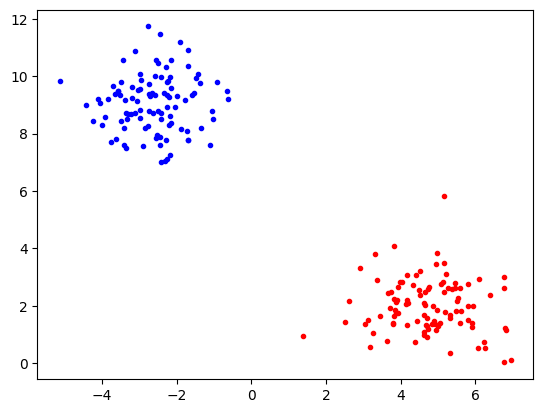

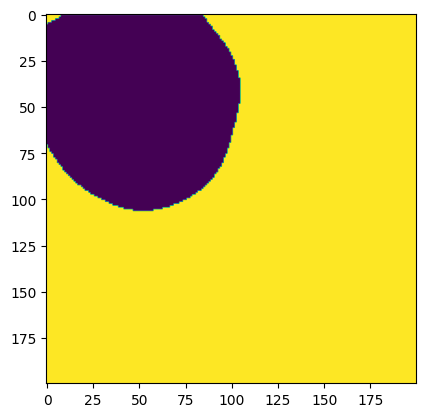

In [4]:
if svm.kernel == "linear":
    x = np.linspace(-6, 8, 50)
    y = -(svm.w[0] * x - svm.b) / svm.w[1]
    plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.', x, y, 'black')

    assert svm.predict(np.array([-2, 10])) == -1
    assert svm.predict(np.array([5, 2])) == 1

else:
    plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')
    prediction_grid = np.zeros((200, 200))

    x = np.linspace(-6, 8, 200)
    y = np.linspace(-1, 12, 200)

    for i in range(200):
        for j in range(200):
            prediction_grid[i,j] = svm.predict(np.array([x[j], y[-i]]))

    plt.figure()
    plt.imshow(prediction_grid)